***Import libraries for the inference***

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T
import cv2
from PIL import Image, ImageChops
from torchsummary import summary
import segmentation_models_pytorch as smp
import albumentations as A

from math import ceil 

***Try to load the model on GPU (cuda) else CPU***

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model=torch.load(r'C:\Users\eflam\Desktop\stagenokia\stage_eflamm\Unet-Mobilenet-full.pt',map_location=device)

cuda


***Function to prepare the RGB image and predict a segmented image/mask***

In [3]:
def predict_image_mask_miou_2(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)]) 
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

***Server is waiting for an RGB image, then two masks are predicted and saved locally on the server.***

In [8]:
#otpion to print all the tensor for debug
np.set_printoptions(threshold=sys.maxsize) 
starting_time=time.time()
#path to take the RGB image and save the masks
RGB_path_gpu =  "C:\\Users\\eflam\\Desktop\\stagenokia\\RGB\\"
mask_path_gpu = "C:\\Users\\eflam\\Desktop\\stagenokia\\mask\\"
#resize the image
transform = A.Resize(960, 1280, interpolation=cv2.INTER_NEAREST)

#full path
filename ="img1.jpg"
path_full_RGB = RGB_path_gpu+filename
#read th RGB image with cv2
frame = cv2.imread(path_full_RGB)

#wait uploading of the Pi
while(frame is None) :
    frame = cv2.imread(path_full_RGB)
    time.sleep(4)


frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #color conversion of the frame
aug = transform(image=frame) 
img = Image.fromarray(aug['image']) #resize the image from the original one 

pred_mask = predict_image_mask_miou_2(model,img) #prediction of a mask (background is hided)
pred_mask.to(device) #send the mask to the device to manipulate it

#confuse the class plant and self-propagating plant because the model is not trained on a large datset.
ped_mask=pred_mask/2
pred_mask=np.ceil(pred_mask)
#print(pred_mask)
tensor_vege=np.array(pred_mask * 255).astype(np.uint8) #tensor containing pixel with values (0;255)
np.save(r"C:\Users\eflam\Desktop\stagenokia\mask\mask_vege.npy",tensor_vege)
    
img = Image.fromarray(tensor_vege) #transform the saved tensor to an image
img_tempo=ImageChops.invert(img) #inverse the value of the pixel in order to have a mask that hides the vegetation
tensor_back=np.array(img_tempo) #transform the image to array/tensor
tensor_back=(tensor_back).astype(np.uint8)
np.save(r"C:\Users\eflam\Desktop\stagenokia\mask\mask_back.npy",tensor_back)

#print(np.max(tensor_vege))
#print(np.max(tensor_back))
#print(tensor_vege)
#print(tensor_back)

mask_name = "mask1.jpg" 
plt.imsave(mask_path_gpu+mask_name,pred_mask) #save the jpg mask that hides the background
   
end_time=time.time()
tot1=end_time-starting_time
print('Temps total pour traiter 1 images :', tot1/100)

Temps total pour traiter 1 images : 0.010327792167663575


***Plot the two masks in numpy format***

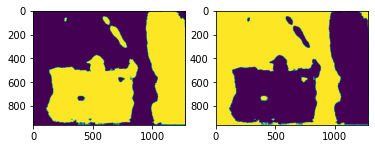

In [9]:
os.chdir(r"C:\Users\eflam\Desktop\stagenokia\mask")
mask_vege=np.load("mask_vege.npy")
mask_back=np.load("mask_back.npy")

plt.figure()
plt.subplot(121)
plt.imshow(mask_vege)
plt.subplot(122)
plt.imshow(mask_back)
plt.show()